In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chi2
from scipy.special import binom
from math import sqrt, floor, factorial

# Статистические свойства

In [2]:
def probabilities(u):
    return np.array([(val, cnt / len(u)) for val, cnt in Counter(u).items()])

def math_exp(probs):
    return np.dot(probs[:, 0], probs[:, 1])

def dispersion(probs):
    squared = np.array([(x * x, p) for x, p in probs])
    return math_exp(squared) - math_exp(probs) ** 2

def std_dev(probs):
    return sqrt(dispersion(probs))

In [3]:
def graph_math_exp(data):
    xs = np.arange(500, 10000 + 1, 500)
    ys = np.array([math_exp(probabilities(data[:x])) for x in xs])

    absolute = abs(ys[9] - ys[-1])
    relative = absolute / ys[9] * 100
    print(
        f'Относительная погрешность измерения математического ожидания '
        f'для выборки из {xs[9]} элементов: {round(relative, 3)}%'
    )

    df = pd.DataFrame({
        'Объём выборки': xs,
        'Математическое ожидание': ys
    })

    sns.lineplot(
        data=df,
        x='Объём выборки',
        y='Математическое ожидание'
    ).set_title(
        'Зависимость мат. ожидания от размера выборки'
    )
    plt.show()

def graph_std_dev(data):
    xs = np.arange(500, 10000 + 1, 500)
    ys = np.array([std_dev(probabilities(data[:x])) for x in xs])

    absolute = abs(ys[9] - ys[-1])
    relative = absolute / ys[9] * 100
    print(
        f'Относительная погрешность измерения среднеквадратичного отклонения '
        f'для выборки из {xs[9]} элементов: {round(relative, 3)}%'
    )

    df = pd.DataFrame({
        'Объём выборки': xs,
        'Cреднеквадратичное отклонение': ys
    })

    sns.lineplot(
        data=df,
        x='Объём выборки',
        y='Cреднеквадратичное отклонение'
    ).set_title(
        'Зависимость среднеквадратичного отклонения от размера выборки'
    )
    plt.show()

# Критерии

## Критерий $\chi$-квадрат

In [4]:
def crit_chi_squared(observed, expected, k, alpha=0.05):
    chi_squared = np.sum(np.square(observed - expected) / expected)
    critical = chi2.ppf(1 - alpha, k - 1)
    result = chi_squared <= critical
    return result

## Критерий серий

In [5]:
def crit_series(data, observed, expected, d=64):
    observed = np.zeros(d * d, dtype=int)
    for i in range(len(data) // 2):
        q, r = floor(data[2 * i] * d), floor(data[2 * i + 1] * d)
        observed[q * d + r] += 1
    
    expected = np.full(d * d, len(data) / (2 * d * d))
    return crit_chi_squared(observed, expected, d * d)

## Критерий интервалов

In [6]:
def crit_intervals(data, q=128, d=16):
    n = len(data)
    m = n // q

    observed = np.zeros(m, dtype=int)
    j, s = -1, 0
    while s != m and j != n:
        j, r = j + 1, 0
        while j != n and data[j] * d < d / 2:
            j, r = j + 1, r + 1
        observed[min(r, m - 1)] += 1
        s += 1

    expected = np.zeros(m)
    p = 0.5
    for r in range(m - 1):
        expected[r] = m * p * (1 - p) ** r
    expected[m - 1] = m * (1 - p) ** m

    return crit_chi_squared(observed, expected, m + 1)

## Критерий разбиений

In [7]:
def stirling2(n, k):
    if n <= 0 or n != 0 and n == k:
        return 1
    elif k <= 0 or n < k:
        return 0
    elif n == 0 and k == 0:
        return -1
    else:
        return k * stirling2(n - 1, k) + stirling2(n - 1, k - 1)
    
def crit_partition(data, k, d=16):
    n = len(data)
    observed = np.zeros(k)
    for i in range(n // k):
        hand = {floor(v * d) for v in data[i * k:(i + 1) * k]}
        observed[len(hand) - 1] += 1

    expected = np.zeros(k)
    for r in range(1, k + 1):
        p = 1.0
        for i in range(r):
            p *= d - i
        expected[r - 1] = (n / k) * (p / d ** k) * stirling2(k, r)

    return crit_chi_squared(observed, expected, k)

## Критерий перестановок

In [8]:
def crit_permutation(data, t=4, d=1024):
    n = len(data)
    t_fact = factorial(t)
    observed = np.zeros(t_fact)
    for i in range(n // t):
        v = [v * d for v in data[t * i:t * i + t]]
        c = np.zeros(t, dtype=int)
        r = t

        while r > 0:
            s = 0
            for j in range(r):
                if v[j] > v[s]:
                    s = j
            c[r - 1] = s
            v[r - 1], v[s] = v[s], v[r - 1]
            r -= 1

        f = 0
        for j in range(t - 1):
            f = (f + c[j]) * (j + 2)
        f += c[t - 1]
        observed[f] += 1

    expected = np.full(t_fact, n / t / t_fact)

    return crit_chi_squared(observed, expected, t_fact)

## Критерий монотонности

In [9]:
def crit_monotonic(data, d=1024):
    last, cnt = data[0] * d, 0
    c = np.zeros(6)
    for x in data[1:]:
        y = x * d
        if y > last:
            cnt += 1
        else:
            c[min(cnt, 5)] += 1
            cnt = 0
        last = y
    c[min(cnt, 5)] += 1

    a = np.array([
        [4529.4,  9044.9,  13568.0, 18091.0,  22615.0,  27892.0],
        [9044.9,  18097.0, 27139.0, 36187.0,  45234.0,  55789.0],
        [13568.0, 27139.0, 40721.0, 54281.0,  67852.0,  83685.0],
        [18091.0, 36187.0, 54281.0, 72414.0,  90470.0,  111580.0],
        [22615.0, 45234.0, 67852.0, 90470.0,  113262.0, 139476.0],
        [27892.0, 55789.0, 83685.0, 111580.0, 139476.0, 172860.0],
    ])
    b = np.array([
        1.0 / 6.0, 5.0 / 24.0, 11.0 / 120.0, 
        19.0 / 720.0, 29.0 / 5040.0, 1.0 / 840.0,
    ])

    n = len(data)
    m = 0.0
    for i in range(6):
        for j in range(6):
            m += (c[i] - n * b[i]) * (c[j] - n * b[j]) * a[i, j]

    return chi2.ppf(0.05, 6) <= m / n <= chi2.ppf(1 - 0.05, 6)

## Критерий конфликтов

In [10]:
def p(n, m, k):
    n = float(n)
    m = float(m)
    k = float(k)
    return binom(n, k) * (m ** (-k)) * (1 - 1 / m) ** (n - k)

def crit_conflicts(data, q=128):
    n = len(data)
    m = n * q
    unique, counts = np.unique(np.uint32(np.floor(np.array(data) * m)), return_counts=True)
    empty = m - unique.shape[0]
    observed = (sum(p(n, m, k) for k in counts) + p(n, m, 0) * empty) / m
    expected = (n / m - 1 + p(n, m, 0)) * m
    return observed < expected

# Проверки критериев

In [11]:
def prepare(xs):
    m, *xs = xs
    return [x / m for x in xs]

files = {
    'Линейный конгруэнтный': 'rnd-lc.dat',
    'Аддитивный': 'rnd-add.dat',
    'Пятипараметрический': 'rnd-5p.dat',
    'РСЛОС': 'rnd-lfsr.dat',
    'Нелинейная комбинация РСЛОС': 'rnd-nfsr.dat',
    'Вихрь Мерсенна': 'rnd-mt.dat',
    'RC4': 'rnd-rc4.dat',
    'RSA': 'rnd-rsa.dat',
    'Алгоритм Блюма-Блюма-Шуба': 'rnd-bbs.dat',
}

data = dict()

for filename in files.values():
    with open(filename) as f:
        xs = list(map(float, f.read().strip().split(',')))
    data[filename] = prepare(xs)

In [12]:
def run_tests(data):
    probs = probabilities(data)
    print(f"Математическое ожидание = {math_exp(probs)}")
    print(f"Среднеквадратичное отклонение = {std_dev(probs)}")
    graph_math_exp(data)
    graph_std_dev(data)
    
    k = 5
    observed = np.zeros(k, dtype=int)
    for val in data:
        for i in range(0, k):
            if i / k <= val < (i + 1) / k:
                observed[i] += 1

    expected = np.full(k, len(data) / k)

    chi = crit_chi_squared(observed, expected, k)
    series = crit_series(data, observed, expected)
    intervals = crit_intervals(data)
    partition = crit_partition(data, k=8)
    permutation = crit_permutation(data)
    monotonic = crit_monotonic(data)
    conflicts = crit_conflicts(data)
    print(f"Критерий хи-квадрат:   {chi}")
    print(f"Критерий серий:        {series}")
    print(f"Критерий интервалов:   {intervals}")
    print(f"Критерий разбиений:    {partition}")
    print(f"Критерий перестановок: {permutation}")
    print(f"Критерий монотонности: {monotonic}")
    print(f"Критерий конфликтов:   {conflicts}")

## Линейный конгруэнтный генератор

Математическое ожидание = 0.4980023437500002
Среднеквадратичное отклонение = 0.28966520307281585
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.642%


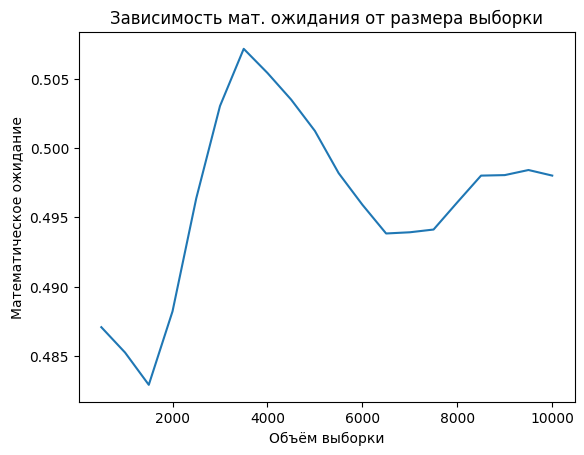

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.048%


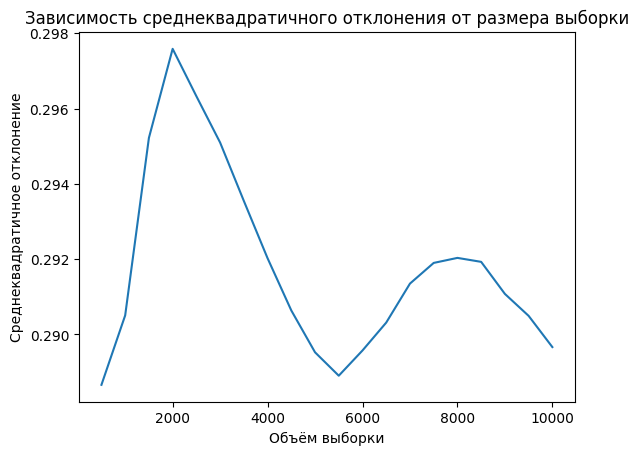

Критерий хи-квадрат:   True
Критерий серий:        False
Критерий интервалов:   True
Критерий разбиений:    True
Критерий перестановок: False
Критерий монотонности: True
Критерий конфликтов:   True


In [13]:
run_tests(data["rnd-lc.dat"])

## Аддитивный генератор

Математическое ожидание = 0.4959591796874994
Среднеквадратичное отклонение = 0.2872104606725695
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.215%


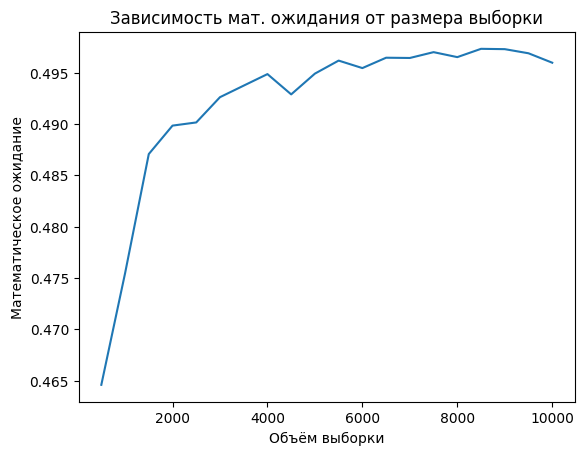

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.224%


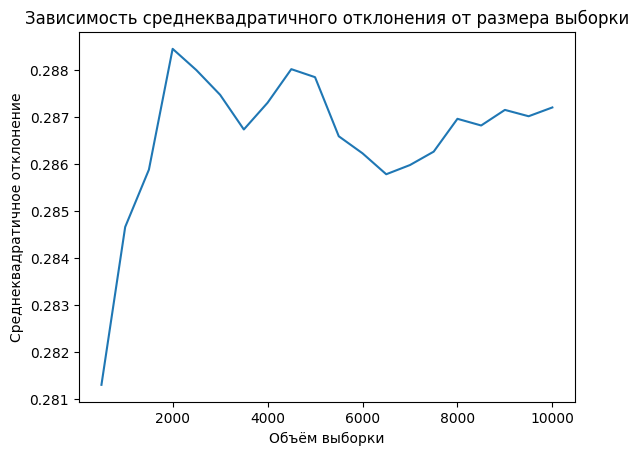

Критерий хи-квадрат:   True
Критерий серий:        True
Критерий интервалов:   True
Критерий разбиений:    True
Критерий перестановок: True
Критерий монотонности: True
Критерий конфликтов:   True


In [14]:
run_tests(data["rnd-add.dat"])

## Пятипараметрический генератор

Математическое ожидание = 0.49790820312500017
Среднеквадратичное отклонение = 0.2899989510155476
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.409%


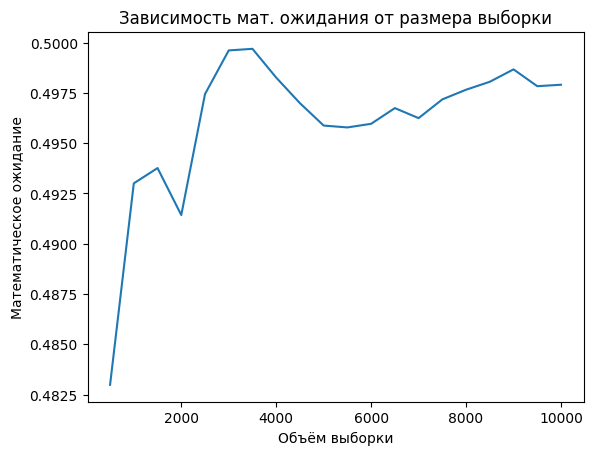

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.003%


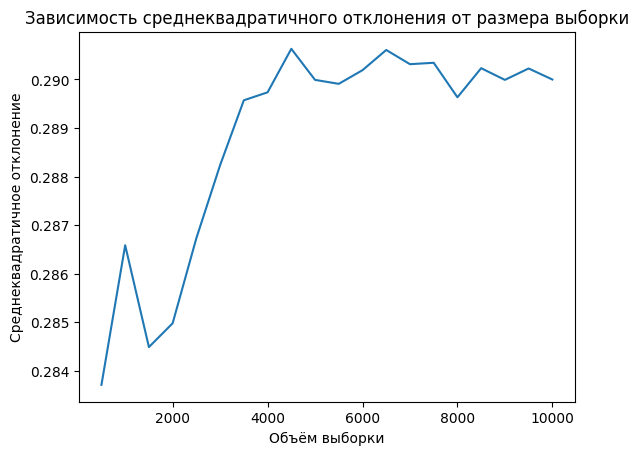

Критерий хи-квадрат:   True
Критерий серий:        True
Критерий интервалов:   True
Критерий разбиений:    True
Критерий перестановок: True
Критерий монотонности: True
Критерий конфликтов:   True


In [15]:
run_tests(data["rnd-5p.dat"])

## РСЛОС

Математическое ожидание = 0.49532001953125054
Среднеквадратичное отклонение = 0.29063739013628703
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.923%


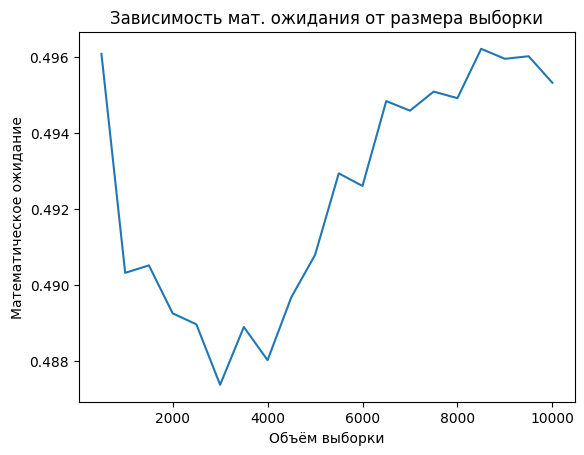

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.613%


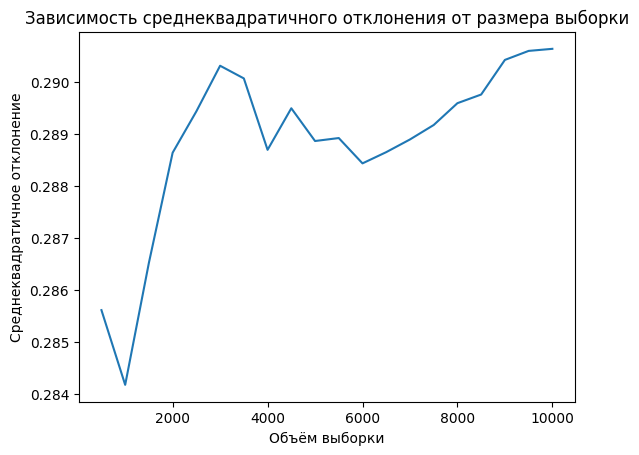

Критерий хи-квадрат:   True
Критерий серий:        True
Критерий интервалов:   True
Критерий разбиений:    True
Критерий перестановок: True
Критерий монотонности: False
Критерий конфликтов:   True


In [16]:
run_tests(data["rnd-lfsr.dat"])

## Нелинейная комбинация РСЛОС

Математическое ожидание = 0.5033218749999994
Среднеквадратичное отклонение = 0.29075993794219074
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.134%


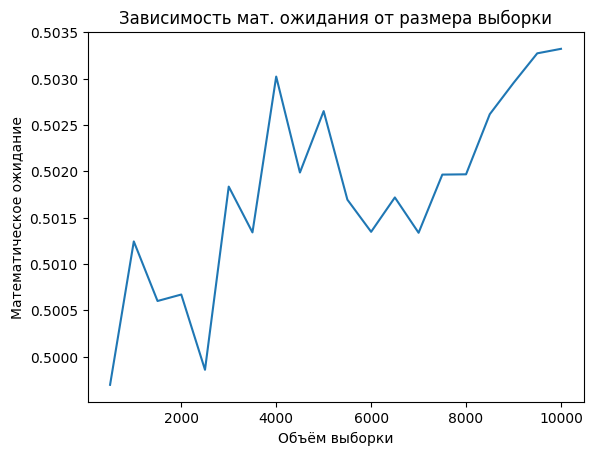

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.497%


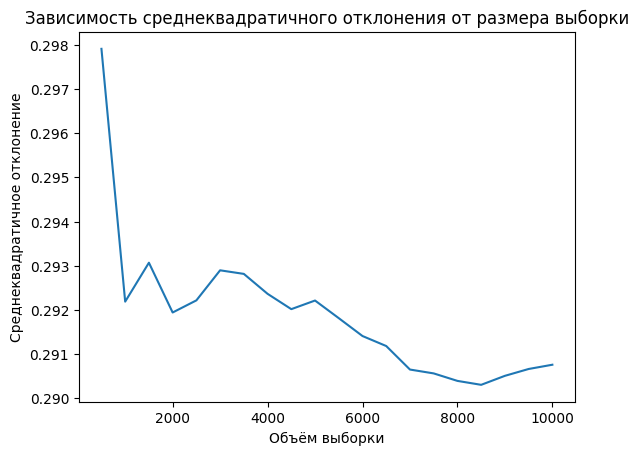

Критерий хи-квадрат:   True
Критерий серий:        False
Критерий интервалов:   True
Критерий разбиений:    False
Критерий перестановок: False
Критерий монотонности: False
Критерий конфликтов:   True


In [17]:
run_tests(data["rnd-nfsr.dat"])

## Вихрь Мерсенна

Математическое ожидание = 0.4987525390624997
Среднеквадратичное отклонение = 0.2883897385970719
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.643%


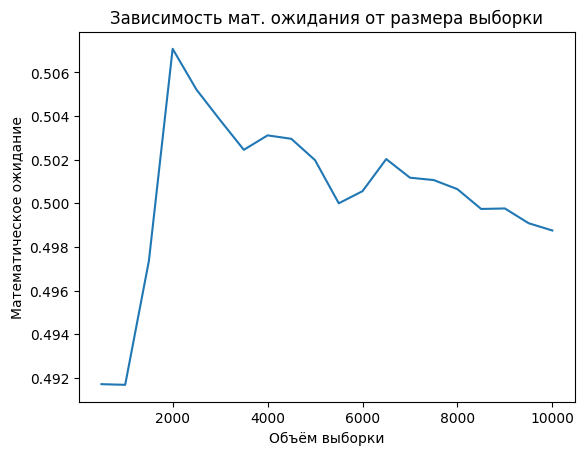

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.469%


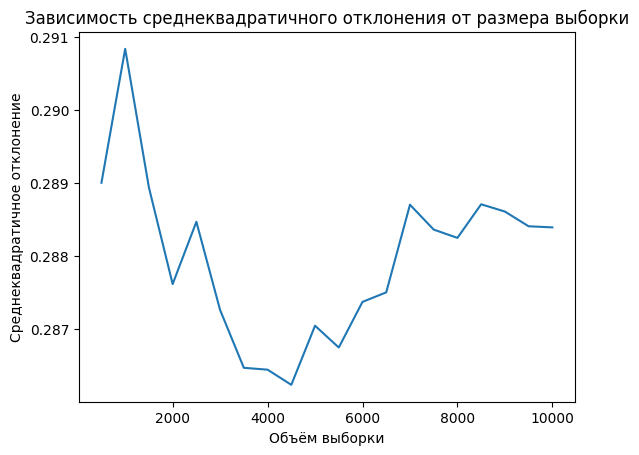

Критерий хи-квадрат:   True
Критерий серий:        True
Критерий интервалов:   True
Критерий разбиений:    True
Критерий перестановок: True
Критерий монотонности: True
Критерий конфликтов:   True


In [18]:
run_tests(data["rnd-mt.dat"])

## RC4

Математическое ожидание = 0.12457070312500011
Среднеквадратичное отклонение = 0.07160578956319438
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.29%


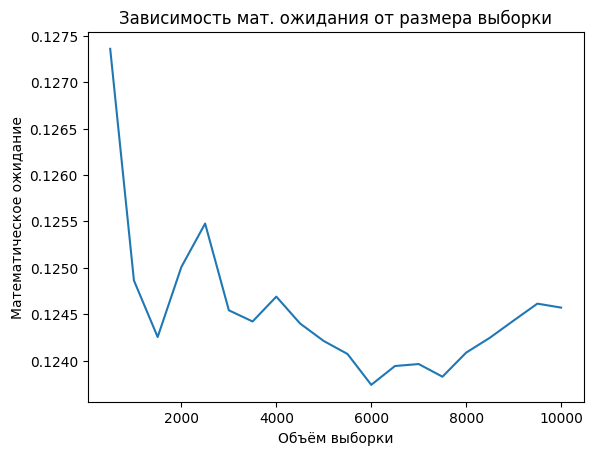

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.003%


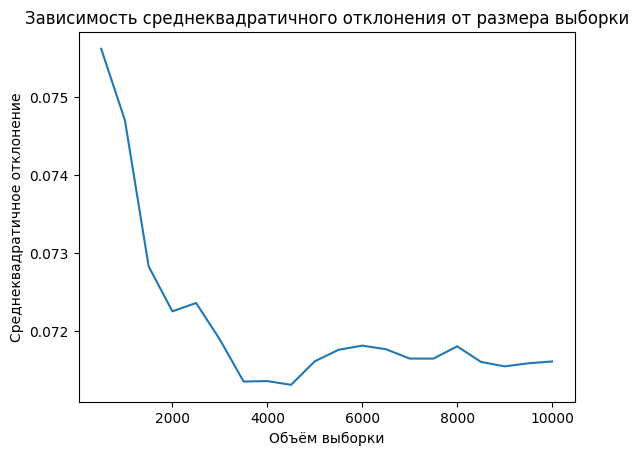

Критерий хи-квадрат:   False
Критерий серий:        False
Критерий интервалов:   False
Критерий разбиений:    False
Критерий перестановок: True
Критерий монотонности: True
Критерий конфликтов:   True


In [19]:
run_tests(data["rnd-rc4.dat"])

## RSA

Математическое ожидание = 0.47569716796875
Среднеквадратичное отклонение = 0.26404647855613683
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.012%


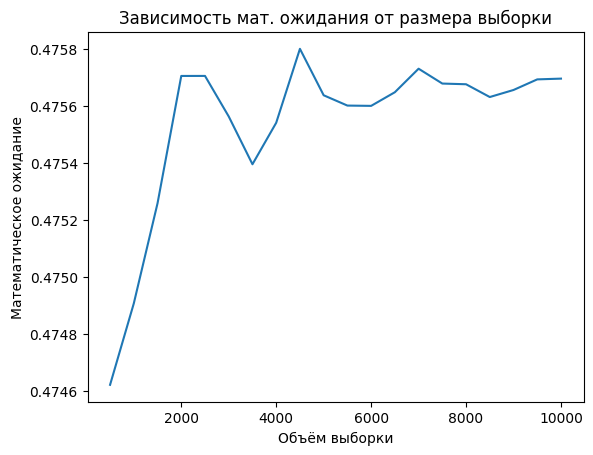

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.01%


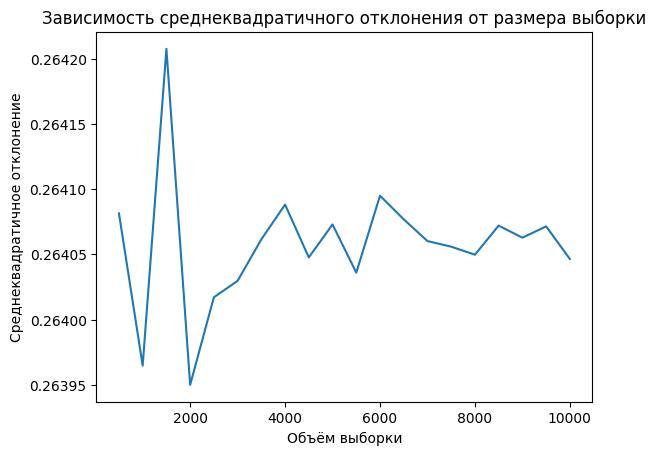

Критерий хи-квадрат:   False
Критерий серий:        False
Критерий интервалов:   True
Критерий разбиений:    False
Критерий перестановок: False
Критерий монотонности: False
Критерий конфликтов:   False


/var/folders/1c/3lw5hs7n7w34w4dldvvgdljw0000gn/T/ipykernel_29435/3568141781.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  return binom(n, k) * (m ** (-k)) * (1 - 1 / m) ** (n - k)


In [20]:
run_tests(data["rnd-rsa.dat"])

## Алгоритм Блюма-Блюма-Шуба

Математическое ожидание = 0.005859765624999999
Среднеквадратичное отклонение = 0.0036539883705292357
Относительная погрешность измерения математического ожидания для выборки из 5000 элементов: 0.01%


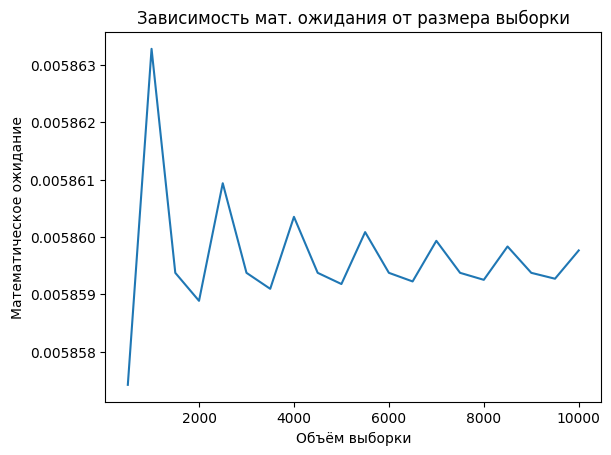

Относительная погрешность измерения среднеквадратичного отклонения для выборки из 5000 элементов: 0.009%


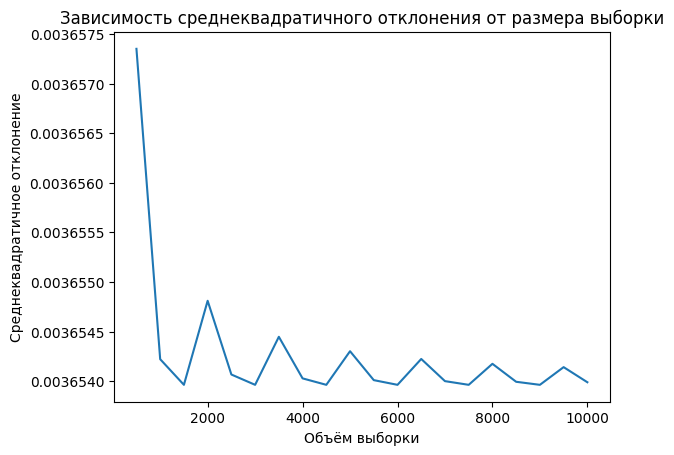

Критерий хи-квадрат:   False
Критерий серий:        False
Критерий интервалов:   False
Критерий разбиений:    False
Критерий перестановок: False
Критерий монотонности: False
Критерий конфликтов:   False


/var/folders/1c/3lw5hs7n7w34w4dldvvgdljw0000gn/T/ipykernel_29435/3568141781.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  return binom(n, k) * (m ** (-k)) * (1 - 1 / m) ** (n - k)


In [21]:
run_tests(data["rnd-bbs.dat"])